# Model Training
This notebook runs through:
- Loading in training data
- GroupKFold for training a model
- Saving hyperparameters for full training (found in Inference notebook)

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

from levee_hunter.levees_dataset import LeveesDataset
from levee_hunter.modeling.groupkfold import GroupKFoldTraining

import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

/home/ucapmgb/.conda/envs/Fathom/lib/python3.11/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/home/ucapmgb/.conda/envs/Fathom/lib/python3.11/site-packages/albumentations/core/validation.py:58: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/share/gpu5/ucapmgb/levee-hunter/levee_hunter/augmentations.py:16: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(
/share/gpu5/ucapmgb/levee-hunter/levee_hunter/augmentations.py:19: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  A.Lambda(
/share/gpu5/ucapmgb/levee-hunter/levee_hunte

### Create the Dataset

In [2]:
dataset = LeveesDataset(
    images_dir='/share/gpu5/ucapmgb/levee-hunter/data/processed/_testing/13_384_invert/images',
    masks_dir='/share/gpu5/ucapmgb/levee-hunter/data/processed/_testing/13_384_invert/masks',
    transform=None,
    weighted=True,
    )

### Loss Function
In this case we've used a combined loss function that uses both BCE and Dice loss weighted equally.

In [3]:
# Define a combined loss function that uses both BCE and Dice loss
class DiceBCELoss(nn.Module):
   def __init__(self, bce_weight=0.5, dice_weight=0.5, mode='binary'):
      super(DiceBCELoss, self).__init__()
      self.bce_weight = bce_weight
      self.dice_weight = dice_weight
      self.bce = nn.BCEWithLogitsLoss()
      self.dice = DiceLoss(mode=mode)
      
   def forward(self, y_pred, y_true):
      bce_loss = self.bce(y_pred, y_true)
      dice_loss = self.dice(y_pred, y_true)
      return self.bce_weight * bce_loss + self.dice_weight * dice_loss

### Device

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Model

In [5]:
model = smp.UnetPlusPlus(
    encoder_name="resnet50", encoder_weights="imagenet", in_channels=1, classes=1
).to(device)

### Optimizer


In [6]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)

### Training

In [7]:
model_path_output = "../models/UnetPlusPlus/Unet-13_384"

In [8]:
fold_results, all_train_losses, all_val_losses, per_image_results = GroupKFoldTraining(
   dataset=dataset, 
   device=device,
   model=model,
   optimizer=optimizer,
   criterion=DiceBCELoss(bce_weight=0.5, dice_weight=0.5),
   model_path_output=model_path_output,
   num_folds=5,
   epochs=10,
   batch_size=16,
)


Starting fold 1/5
beginning training on device: cuda
Model successfully saved to: ../models/UnetPlusPlus/Unet-13_384_1.pth
Model successfully saved to: ../models/UnetPlusPlus/Unet-13_384_1.pth
Model successfully saved to: ../models/UnetPlusPlus/Unet-13_384_1.pth
Model successfully saved to: ../models/UnetPlusPlus/Unet-13_384_1.pth
Model successfully saved to: ../models/UnetPlusPlus/Unet-13_384_1.pth
Model successfully saved to: ../models/UnetPlusPlus/Unet-13_384_1.pth
Model successfully saved to: ../models/UnetPlusPlus/Unet-13_384_1.pth
Model successfully saved to: ../models/UnetPlusPlus/Unet-13_384_1.pth
Model successfully saved to: ../models/UnetPlusPlus/Unet-13_384_1.pth
Model successfully saved to: ../models/UnetPlusPlus/Unet-13_384_1.pth
Trained UnetPlusPlus model with ResNetEncoder encoder.
Calculating overall metrics for this fold...

Fold 1 metrics: 
Dice=0.9975, 
IoU=0.9975, 
Distance=0.0007, 
Val Loss=0.0316
Starting fold 2/5
beginning training on device: cuda
Model successfu

### Fold Results


In [9]:
# Combine per-image results across all folds
all_per_image_results = pd.concat(per_image_results, ignore_index=True)
# Convert results to floats
all_per_image_results['dice'] = all_per_image_results['dice'].astype(float)
all_per_image_results['iou'] = all_per_image_results['iou'].astype(float)
all_per_image_results['distance'] = all_per_image_results['distance'].astype(float)


# Summarize results across folds
df_results = pd.DataFrame(fold_results)
print("K-fold Cross Validation Results:")
print(df_results)
print("\nMean results across all folds:")
print(df_results.drop('fold', axis=1).mean())

K-fold Cross Validation Results:
   fold      dice       iou  distance  val_loss
0     1  0.997529  0.997529  0.000668  0.031633
1     2  0.998635  0.998635  0.001242  0.018529
2     3  0.998502  0.998502  0.001650  0.018377
3     4  0.998734  0.998734  0.001432  0.015510
4     5  0.999036  0.999036  0.001170  0.013343

Mean results across all folds:
dice        0.998487
iou         0.998487
distance    0.001232
val_loss    0.019478
dtype: float64


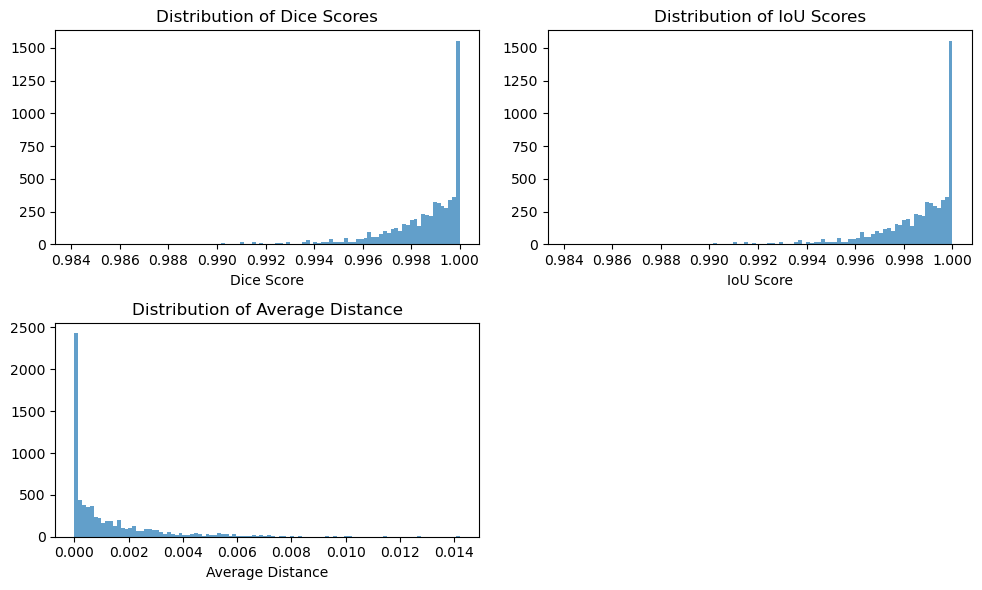

In [10]:
# Visualize per-image metric distributions
plt.figure(figsize=(10, 6))

plt.subplot(2, 2, 1)
plt.hist(all_per_image_results['dice'], bins=100, alpha=0.7, density=True)
plt.title('Distribution of Dice Scores')
plt.xlabel('Dice Score')

plt.subplot(2, 2, 2)
plt.hist(all_per_image_results['iou'], bins=100, alpha=0.7, density=True)
plt.title('Distribution of IoU Scores')
plt.xlabel('IoU Score')

plt.subplot(2, 2, 3)
plt.hist(all_per_image_results['distance'], bins=100, alpha=0.7, density=True)
plt.title('Distribution of Average Distance')
plt.xlabel('Average Distance')

plt.tight_layout()
plt.show()